<a href="https://colab.research.google.com/github/modelonulo/ml-based-intrusion-detection-system/blob/master/ml_ids_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy scikit-learn pydotplus matplotlib 

In [35]:
import os 
import glob
import pandas as pd


import numpy as np
import urllib

import sklearn as sk

from sklearn import tree
from sklearn import  model_selection
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from six import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image  
from IPython.display import display
import pydotplus


from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier 


import matplotlib

%matplotlib inline
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import time
import pickle

from pathlib import Path
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold,cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier ###
from sklearn import svm

from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as metrics

In [5]:
base_path = "/content/drive/MyDrive/Colab Notebooks/ml-ids-colab"

In [6]:
combined_csv = pd.read_csv(base_path + '/combined_data.csv').drop(['Unnamed: 0'], axis = 1)

In [7]:
print(combined_csv.shape)


(2830743, 79)


In [ ]:
'''
os.chdir("/home/camila/workspace/ml-ids")
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
print(all_filenames)
'''

'\nos.chdir("/home/camila/workspace/ml-ids")\nextension = \'csv\'\nall_filenames = [i for i in glob.glob(\'*.{}\'.format(extension))]\nprint(all_filenames)\n'

In [ ]:
'''
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')
'''

'\ncombined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])\ncombined_csv.to_csv( "combined_csv.csv", index=False, encoding=\'utf-8-sig\')\n'

In [8]:
combined_csv = combined_csv.rename(columns=str.lower)
combined_csv.columns = combined_csv.columns.str.lstrip()
combined_csv.columns = combined_csv.columns.str.replace(' ','_')

In [9]:
combined_csv.head(5)

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes/s,flow_packets/s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets/s,bwd_packets/s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down/up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length.1,fwd_avg_bytes/bulk,fwd_avg_packets/bulk,fwd_avg_bulk_rate,bwd_avg_bytes/bulk,bwd_avg_packets/bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,88,640,7,4,440,358,220,0,62.857143,107.349008,179,0,89.5,103.345698,1246875.000,17187.500000,64.000000,135.557286,445,1,640,106.666667,194.325157,497,1,538,179.333333,303.686242,530,4,0,0,0,0,164,104,10937.500000,6250.000000,0,220,66.500000,99.001837,9801.363636,0,0,0,1,0,0,0,0,0,72.545455,62.857143,89.5,164,0,0,0,0,0,0,7,440,4,358,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,88,900,9,4,600,2944,300,0,66.666667,132.287566,1472,0,736.0,849.859596,3937777.778,14444.444440,75.000000,192.795228,684,1,900,112.500000,252.411229,734,1,766,255.333333,435.323251,758,3,0,0,0,0,204,104,10000.000000,4444.444444,0,1472,253.142857,527.434262,278186.901100,0,0,0,1,0,0,0,0,0,272.615385,66.666667,736.0,204,0,0,0,0,0,0,9,600,4,2944,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1205,7,4,2776,2830,1388,0,396.571429,677.274651,1415,0,707.5,816.950631,4652282.158,9128.630705,120.500000,236.433336,777,1,1205,200.833333,397.058392,1008,1,927,309.000000,491.647231,876,1,0,0,0,0,164,104,5809.128631,3319.502075,0,1415,467.166667,690.098917,476236.515200,0,0,0,1,0,0,0,0,0,509.636364,396.571429,707.5,164,0,0,0,0,0,0,7,2776,4,2830,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,88,511,7,4,452,370,226,0,64.571429,110.276708,185,0,92.5,106.809800,1608610.568,21526.418790,51.100000,90.767652,299,1,511,85.166667,131.900594,349,1,462,154.000000,224.719826,412,1,0,0,0,0,164,104,13698.630140,7827.788650,0,226,68.500000,101.933579,10390.454550,0,0,0,1,0,0,0,0,0,74.727273,64.571429,92.5,164,0,0,0,0,0,0,7,452,4,370,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,773,9,4,612,2944,306,0,68.000000,134.933317,1472,0,736.0,849.859596,4600258.732,16817.593790,64.416667,148.698266,531,1,773,96.625000,196.665733,580,1,675,225.000000,348.901132,627,1,0,0,0,0,204,104,11642.949550,5174.644243,0,1472,254.000000,527.520762,278278.153800,0,0,0,1,0,0,0,0,0,273.538462,68.000000,736.0,204,0,0,0,0,0,0,9,612,4,2944,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [10]:
combined_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   destination_port             int64  
 1   flow_duration                int64  
 2   total_fwd_packets            int64  
 3   total_backward_packets       int64  
 4   total_length_of_fwd_packets  int64  
 5   total_length_of_bwd_packets  int64  
 6   fwd_packet_length_max        int64  
 7   fwd_packet_length_min        int64  
 8   fwd_packet_length_mean       float64
 9   fwd_packet_length_std        float64
 10  bwd_packet_length_max        int64  
 11  bwd_packet_length_min        int64  
 12  bwd_packet_length_mean       float64
 13  bwd_packet_length_std        float64
 14  flow_bytes/s                 float64
 15  flow_packets/s               float64
 16  flow_iat_mean                float64
 17  flow_iat_std                 float64
 18  flow_iat_max                 int64  
 19  

In [11]:
combined_csv.isnull().any().any()

True

In [12]:
combined_csv = combined_csv.replace([np.inf, -np.inf], np.nan)
combined_csv = combined_csv.dropna()
combined_csv.isnull().any().any()

False

In [13]:
combined_csv['label'].value_counts()

BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: label, dtype: int64

In [14]:
combined_csv = combined_csv.replace(['Heartbleed', 'Web Attack � Sql Injection', 'Infiltration'], np.nan)
combined_csv = combined_csv.dropna()

In [15]:
combined_csv["label"] =  combined_csv.label.str.replace('[^\x00-\x7F]','')

combined_csv["label"] = combined_csv.label.replace('\s+', ' ', regex=True)

In [16]:
combined_csv['label'].value_counts()

BENIGN                    2271320
DoS Hulk                   230124
PortScan                   158804
DDoS                       128025
DoS GoldenEye               10293
FTP-Patator                  7935
SSH-Patator                  5897
DoS slowloris                5796
DoS Slowhttptest             5499
Bot                          1956
Web Attack Brute Force       1507
Web Attack XSS                652
Name: label, dtype: int64

In [17]:
combined_csv['network_flow'] = np.where(combined_csv['label'] == 'BENIGN', 0, 1)

In [18]:
attack_description = {'BENIGN': 'benign', 
                'DoS Hulk': 'dos',
                'PortScan': 'probe', 
                'DDoS': 'ddos',
                'DoS GoldenEye': 'dos', 
                'FTP-Patator': 'brute_force',
                'SSH-Patator': 'brute_force', 
                'DoS slowloris': 'dos', 
                'DoS Slowhttptest': 'dos',
                'Bot': 'botnet',
                'Web Attack Brute Force': 'web_attack', 
                'Web Attack XSS': 'web_attack'}

combined_csv['network_flow_description'] = combined_csv['label'].map(lambda x: attack_description[x])
combined_csv['network_flow_description'].value_counts()

benign         2271320
dos             251712
probe           158804
ddos            128025
brute_force      13832
web_attack        2159
botnet            1956
Name: network_flow_description, dtype: int64

Text(0.5, 1.0, 'Quantity of bad and good network flow')

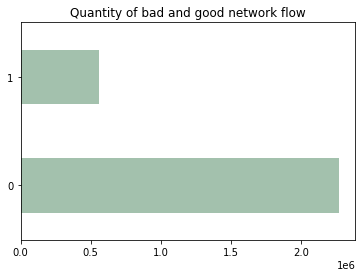

In [19]:
network_flow_counts = combined_csv['network_flow'].value_counts()
network_flow_counts.plot(kind='barh', color='#a3c1ad')
plt.title('Quantity of bad and good network flow') 

In [20]:
#incluir na funcao x
labels = ['label', 'network_flow', 'network_flow_description']
xs = combined_csv.drop(labels, axis=1) 
ys = combined_csv[['label', 'network_flow', 'network_flow_description']] 

x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2, random_state=1, stratify=ys['network_flow'])
#temp = test
#x_test, x_validate, y_test, y_validate = train_test_split(x_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp['label'])


In [21]:
# incluir em func x
min_max_scaler = MinMaxScaler().fit(x_train)

x_train = min_max_scaler.transform(x_train)
#x_validate = min_max_scaler.transform(x_validate)
x_test = min_max_scaler.transform(x_test)

pd.Series(x_train.flatten()).describe()

count    1.764552e+08
mean     8.916510e-02
std      2.579515e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.166667e-07
75%      4.629630e-03
max      1.000000e+00
dtype: float64

In [ ]:

print(combined_csv.shape)

(2827808, 81)


In [ ]:
'''#less
remove_n = 2799999
drop_indices = np.random.choice(combined_csv.index, remove_n, replace=False)
combined_csv2 = combined_csv.drop(drop_indices)
print(combined_csv2.shape) 

(27809, 81)


In [ ]:
'''#less
labels = ['label', 'network_flow', 'network_flow_description']
xs = combined_csv2.drop(labels, axis=1) 
ys = combined_csv2[['label', 'network_flow', 'network_flow_description']] 

x_train, x_temp, y_train, y_temp = train_test_split(xs, ys, test_size=0.4, random_state=1, stratify=ys['label'])
x_test, x_validate, y_test, y_validate = train_test_split(x_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp['label'])

In [ ]:
'''#less
com dataset menor
min_max_scaler = MinMaxScaler().fit(x_train)

x_train = min_max_scaler.transform(x_train)
x_validate = min_max_scaler.transform(x_validate)
x_test = min_max_scaler.transform(x_test)

pd.Series(x_train.flatten()).describe()

In [ ]:
# importance weights with sklearn-RandomForestRegressor
import time
seconds = time.time()
clft_toget_importance_weights = sk.ensemble.RandomForestRegressor(n_estimators=250,random_state=0)
clft_toget_importance_weights.fit(x_train, y_train.network_flow)

with open('/content/drive/MyDrive/Colab Notebooks/ml-ids-colab/get_weights_pickle', 'wb') as f:
  pickle.dump(clft_toget_importance_weights, f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/ml-ids-colab/get_weights_pickle', 'rb') as f:
  get_weights_pickle_loaded = pickle.load(f)

values_importances = get_weights_pickle_loaded.feature_importances_
print(values_importances)

[1.55478136e-01 8.81884446e-04 4.38907707e-04 1.33694212e-04
 6.57876569e-04 1.59114076e-04 3.76808690e-03 4.63032623e-04
 1.04371550e-04 9.46030643e-04 7.54887102e-04 4.17561371e-04
 1.24379714e-03 3.77049831e-01 1.17201402e-03 2.84521012e-03
 1.60519051e-03 1.40481202e-03 8.56566811e-04 5.55928630e-03
 4.69176660e-04 3.81596101e-03 1.88875236e-04 7.98976279e-04
 9.70795461e-04 5.66690911e-05 1.04452771e-03 2.00143270e-03
 8.33242292e-05 1.18271350e-03 3.01448289e-04 0.00000000e+00
 1.17824117e-07 0.00000000e+00 8.77236049e-07 6.85971902e-06
 3.62288711e-03 1.82835254e-03 3.14688814e-04 1.78328768e-04
 1.49582292e-03 6.27324196e-02 6.20984468e-04 4.07692159e-05
 2.83912268e-04 7.33487698e-08 2.88863257e-03 1.92229854e-02
 7.36253846e-04 0.00000000e+00 2.94956500e-08 2.40266086e-04
 1.95834407e-01 9.20975945e-05 1.32915824e-03 1.24156632e-06
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.28042479e-04 6.65622207e-04
 1.03923138e-04 1.566780

In [ ]:
names_col = list(combined_csv.columns.values)[0:78] #[::-1]
features_values_importance = pd.DataFrame({'Features':names_col[0:15],'importance':values_importances[0:15]})
features_values_importance = features_values_importance.sort_values('importance',ascending=False).set_index('Features')

,importance
Features,
bwd_packet_length_std,0.377050
destination_port,0.155478
fwd_packet_length_max,0.003768
bwd_packet_length_mean,0.001244
flow_bytes/s,0.001172
fwd_packet_length_std,0.000946
flow_duration,0.000882
bwd_packet_length_max,0.000755
total_length_of_fwd_packets,0.000658


Text(0, 0.5, 'Importance')

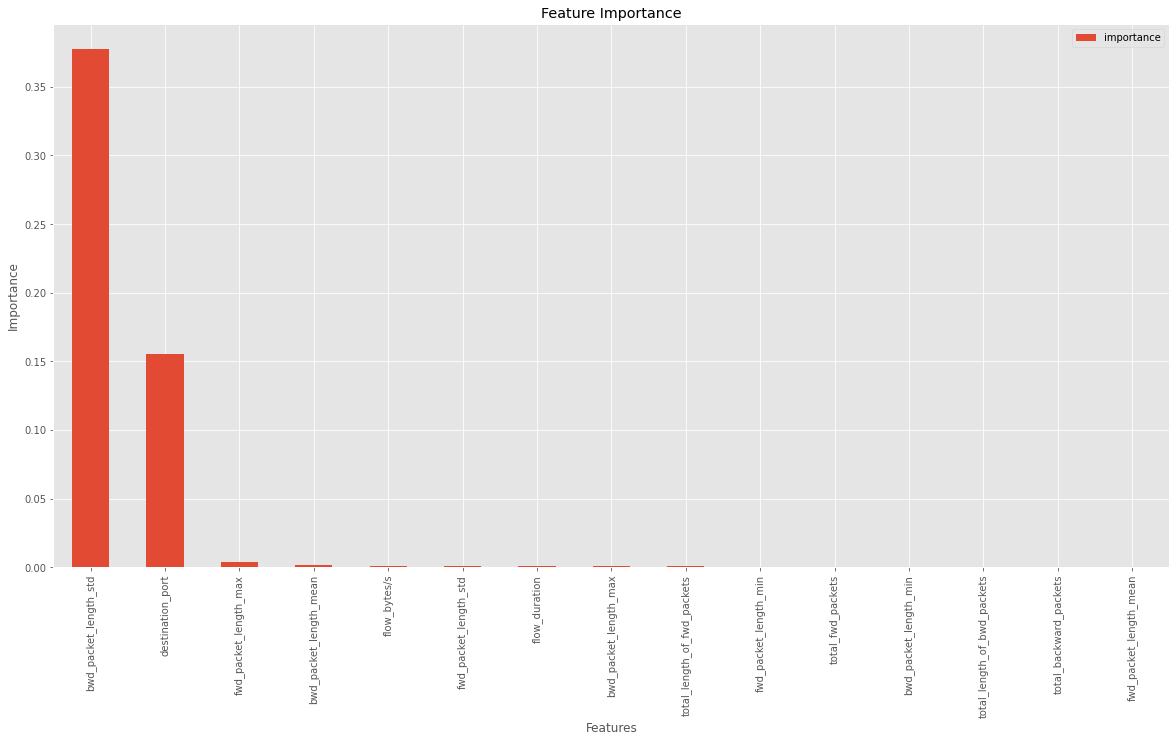

In [ ]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 10)
features_values_importance.plot.bar();
plt.title('Feature Importance')
plt.ylabel('Importance')

In [22]:
#9
def keep_cols(df, to_keep):

    to_drop = list(set(list(df)) - set(to_keep))
    return df.drop(to_drop, axis = 1)

features_to_use = combined_csv.pipe(keep_cols, ['bwd_packet_length_std	', 'destination_port', 
                                                     'fwd_packet_length_max', 'bwd_packet_length_mean', 'flow_bytes/s', 'fwd_packet_length_std', 'flow_duration', 'bwd_packet_length_max', 'total_length_of_fwd_packets','label'])
features_to_use.head()

,destination_port,flow_duration,total_length_of_fwd_packets,fwd_packet_length_max,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_mean,flow_bytes/s,label
0,88,640,440,220,107.349008,179,89.5,1246875.000,BENIGN
1,88,900,600,300,132.287566,1472,736.0,3937777.778,BENIGN
2,88,1205,2776,1388,677.274651,1415,707.5,4652282.158,BENIGN
3,88,511,452,226,110.276708,185,92.5,1608610.568,BENIGN
4,88,773,612,306,134.933317,1472,736.0,4600258.732,BENIGN


In [23]:
x = features_to_use.iloc[:,0:7].values
y = features_to_use.iloc[:, 8].values #label

In [24]:
len(x)

2827808

In [25]:
scaler = MinMaxScaler()
scaler.fit_transform(x)
pd.Series(x.flatten()).describe()

count    1.979466e+07
mean     2.115660e+06
std      1.373791e+07
min     -1.300000e+01
25%      6.000000e+00
50%      6.500000e+01
75%      4.200000e+02
max      1.200000e+08
dtype: float64

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

modelos1 = [LogisticRegression(solver='liblinear'), RandomForestClassifier(n_estimators=400, random_state=42), 
          DecisionTreeClassifier(random_state=42), svm.SVC(kernel='rbf', gamma='scale', random_state=42), 
          KNeighborsClassifier()]

In [ ]:
#modelos1
mean=[]
std=[]
for model in modelos1:
    result = cross_val_score(model, x, y, cv=kfold, scoring="accuracy", n_jobs=-1)
    mean.append(result)
    std.append(result)

metricas1 = {"mean": mean, "std": std}

with open('/content/drive/MyDrive/Colab Notebooks/ml-ids-colab/metricas1_pickle', 'wb') as f:
  pickle.dump(metricas1, f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/ml-ids-colab/metricas_pickle', 'rb') as f:
  metricas_pickle = pickle.load(f)

mean = metricas_pickle["mean"] #.get("metricas") nao mostra o erro 
std = metricas_pickle["std"]

In [ ]:
print(mean)

[array([0.85904351, 0.85580726, 0.85616685, 0.85257102, 0.85901816]), array([0.98975189, 0.99029126, 0.99011147, 0.99208918, 0.99028952]), array([0.9893923 , 0.98651564, 0.98903272, 0.98867314, 0.98741234]), array([0.8425027 , 0.83477166, 0.84591873, 0.83225458, 0.84337349]), array([0.90255304, 0.90093492, 0.90453074, 0.90165408, 0.89768027])]


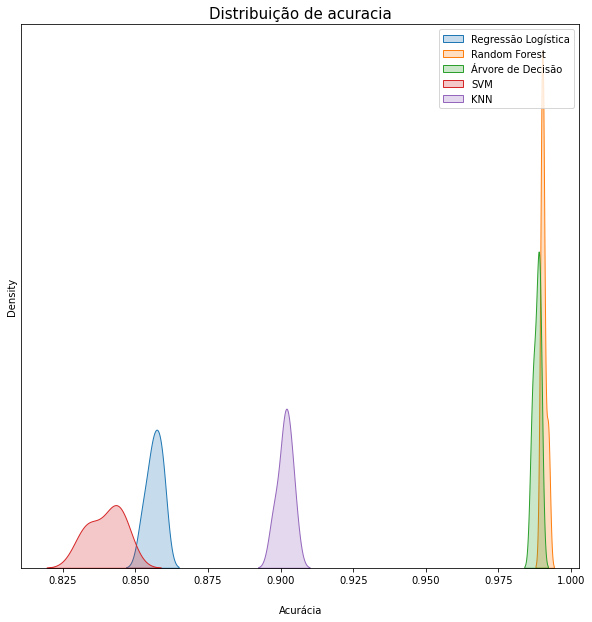

In [ ]:
classificadores=['Regressão Logística', 'Random Forest', 'Árvore de Decisão', 'SVM', 'KNN']

plt.figure(figsize=(10, 10))
for i in range(len(mean)):
    sns.distplot(mean[i], hist=False, kde_kws={"shade": True})
    
plt.title("Distribuição de acuracia", fontsize=15)
plt.legend(classificadores)
plt.xlabel("Acurácia", labelpad=20)
plt.yticks([])

plt.show()

In [30]:
#arvores de decisao e a floresta randomica
#svm_clf = svm.SVC(C=0.9, gamma=0.1, kernel='rbf', probability=True, random_state=42)
dt_clf = DecisionTreeClassifier(random_state = 42)
rf_clf = RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42)

# Treina os modelos
dt_clf.fit(x_train, y_train.network_flow)
rf_clf.fit(x_train, y_train.network_flow)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [33]:
# obtém as probabilidades previstas
clf_prob = dt_clf.predict_proba(x_test)
rf_prob = rf_clf.predict_proba(x_test)

# Valores reais
clf_preds = np.argmax(clf_prob, axis=1)
rf_preds = np.argmax(rf_prob, axis=1)


In [42]:
y_test

,label,network_flow,network_flow_description
800072,BENIGN,0,benign
1580531,BENIGN,0,benign
546043,DoS Hulk,1,dos
1929690,BENIGN,0,benign
1065588,BENIGN,0,benign
...,...,...,...
2092307,PortScan,1,probe
20163,BENIGN,0,benign
2126334,BENIGN,0,benign
2124179,PortScan,1,probe


[Text(570.5454545454544, 0.5, 'Valor Real'), Text(0.5, 24.0, 'Previsao')]

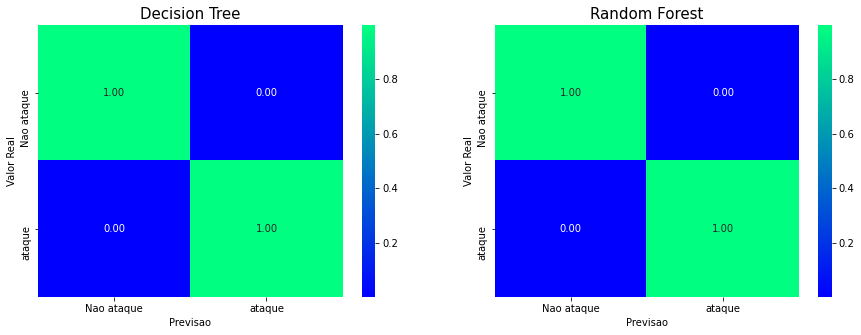

In [44]:
#analisando os modelos 
cm = metrics.confusion_matrix(y_test.network_flow, clf_preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm2 = metrics.confusion_matrix(y_test.network_flow, rf_preds)
cm2 = cm2.astype('float') / cm2.sum(axis=1)[: , np.newaxis]

classes = ["Nao ataque", "ataque"]
f, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title("Decision Tree", fontsize=15.)
sns.heatmap(pd.DataFrame(cm, index=classes, columns=classes), 
            cmap='winter', annot=True, fmt='.2f', ax=ax[0]).set(xlabel="Previsao", ylabel="Valor Real")

ax[1].set_title("Random Forest", fontsize=15.)
sns.heatmap(pd.DataFrame(cm2, index=classes, columns=classes), 
            cmap='winter', annot=True, fmt='.2f', ax=ax[1]).set(xlabel="Previsao", 
                                                                ylabel="Valor Real")